<a href="https://colab.research.google.com/github/farahwadya/Car-insurance-intermediate-machine-learning-project/blob/main/Car_insurance_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# upload packages

In [4]:
import pandas as pd

# Dataset

In [5]:
fpath='/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Car_Insurance_Claim.csv'
df=pd.read_csv(fpath)
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [6]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


In [7]:
df.shape

(10000, 19)

In [8]:
df['OUTCOME'].unique()

array([0., 1.])

# Data cleaning

## Data type and inconsistent

In [9]:
print(df.dtypes)

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object


### Age

In [10]:
df['AGE'].unique()

array(['65+', '16-25', '26-39', '40-64'], dtype=object)

In [11]:
age_map = {
    '16-25': 'Young',
    '26-39': 'Adult',
    '40-64': 'Middle-aged',
    '65+': 'Senior'
}
df['AGE'] = df['AGE'].map(age_map)

In [12]:
df['AGE'].unique()

array(['Senior', 'Young', 'Adult', 'Middle-aged'], dtype=object)

In [13]:
df['GENDER'].unique()

array(['female', 'male'], dtype=object)

In [14]:
df['RACE'].unique()

array(['majority', 'minority'], dtype=object)

In [15]:
df['DRIVING_EXPERIENCE'].unique()

array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object)

In [16]:
df['EDUCATION'].unique()

array(['high school', 'none', 'university'], dtype=object)

In [17]:
df['INCOME'].unique()

array(['upper class', 'poverty', 'working class', 'middle class'],
      dtype=object)

In [18]:
df['VEHICLE_YEAR'].unique()

array(['after 2015', 'before 2015'], dtype=object)

In [19]:
df['VEHICLE_TYPE'].unique()

array(['sedan', 'sports car'], dtype=object)

### Driving experience

In [20]:
experience_map = {
    '0-9y': 'Novice (0-9y)',
    '10-19y': 'Intermediate (10-19y)',
    '20-29y': 'Experienced (20-29y)',
    '30y+': 'Expert (30y+)'
}

df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].map(experience_map)

## null values

In [23]:
df.isna().sum()

,0
ID,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,982
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0


## duplicates

In [22]:
df.duplicated().sum()

np.int64(0)

# Exploration

In [24]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Senior,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


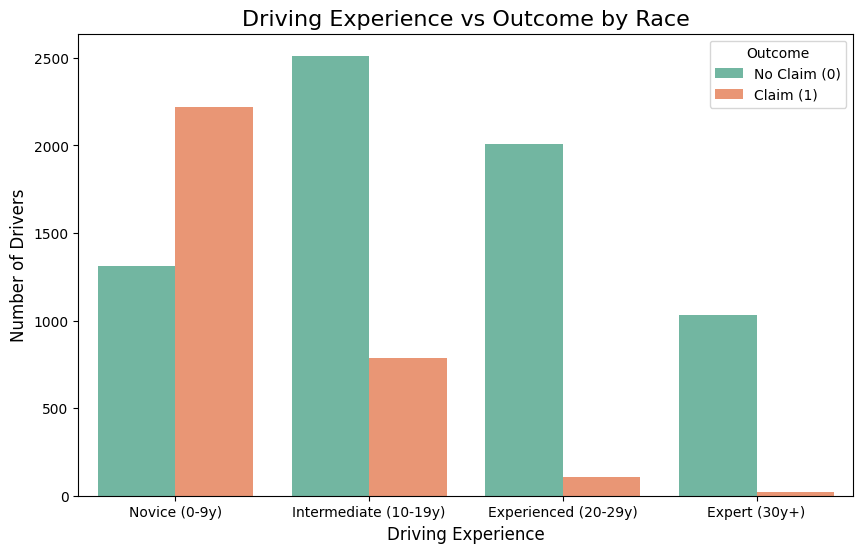

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10,6))

# Plot countplot: Driving Experience vs Outcome, colored by OUTCOME
sns.countplot(
    data=df,
    x='DRIVING_EXPERIENCE',
    hue='OUTCOME',
    palette='Set2',
    dodge=True
)

# Add title and axis labels
plt.title('Driving Experience vs Outcome by Race', fontsize=16)
plt.xlabel('Driving Experience', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

# Customize legend
plt.legend(title='Outcome', labels=['No Claim (0)', 'Claim (1)'])

# Show plot
plt.show()


This visualization shows that driving experience affects the insurance outcome. Novice drivers (0-9y) have the highest number of claims, while more experienced drivers (20-29y and 30y+) tend to have fewer claims. This indicates a negative correlation between driving experience and the likelihood of filing a claim.

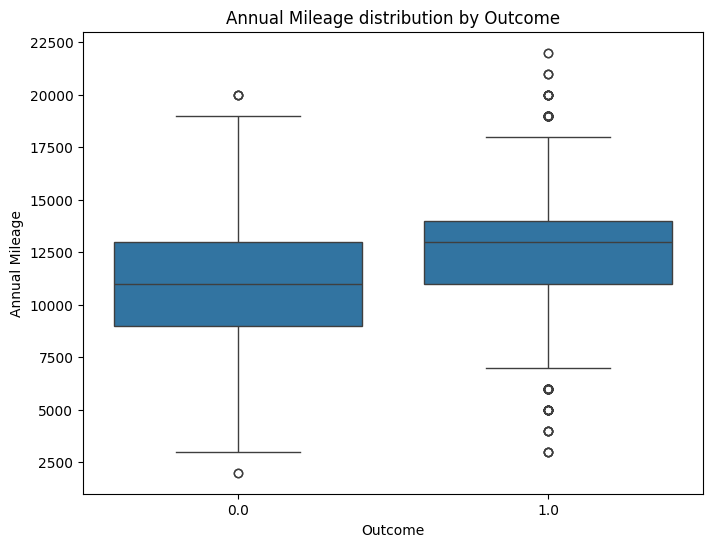

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# نفترض إن df موجود مسبقًا ويحتوي على العمودين
# df = pd.read_csv('your_dataset.csv')

plt.figure(figsize=(8,6))
sns.boxplot(x='OUTCOME', y='ANNUAL_MILEAGE', data=df)
plt.xlabel('Outcome')
plt.ylabel('Annual Mileage')
plt.title('Annual Mileage distribution by Outcome')
plt.show()


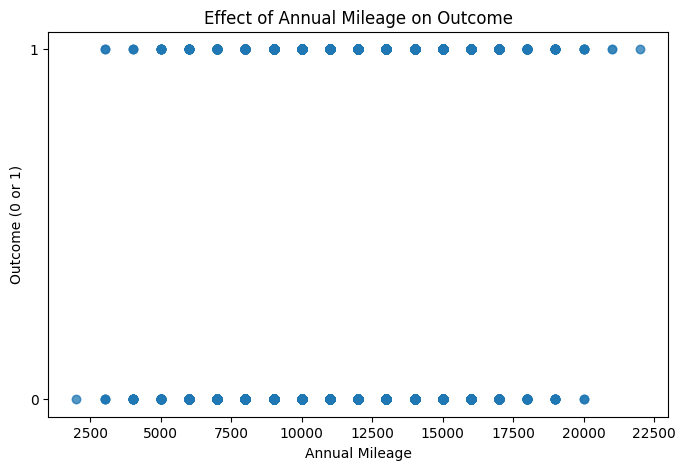

In [27]:
import matplotlib.pyplot as plt

# Scatter plot يوضح العلاقة بين Annual Mileage و Outcome
plt.figure(figsize=(8,5))
plt.scatter(df['ANNUAL_MILEAGE'], df['OUTCOME'], alpha=0.5)
plt.xlabel('Annual Mileage')
plt.ylabel('Outcome (0 or 1)')
plt.title('Effect of Annual Mileage on Outcome')
plt.yticks([0,1])
plt.show()
